In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import sys

URL = "https://fr.wikipedia.org/wiki/Liste_de_sondages_sur_l'%C3%A9lection_pr%C3%A9sidentielle_fran%C3%A7aise_de_2017#2016"

def loadHTML(URL):
    resultats = requests.get(URL)
    return BeautifulSoup(resultats.text, 'html.parser')


def loadPandas(URL):
    tables = loadHTML(URL).findAll("table")

    dfF = pd.DataFrame()
    dfFs = pd.DataFrame()
    #Pour chaque table de wikipedia :
    for table in tables :
        lignes = table.findAll("tr")

        #On récupère le nom de chaque colonne :
        colonnes = []
        for elem in lignes[0].findAll("th"):
            if elem.find("a") is None :
                colonnes.append(elem.text)
            else :
                if(elem.find("a").text != ""):
                    colonnes.append(elem.find("a").text)
        if len(colonnes) < 7:
            for elem in lignes[2].findAll("th"):
                a=3
                colonnes.append(elem.text)

        #On crée un pandas dataframe pour stocker nos table :
        df = pd.DataFrame(columns = colonnes)

        #print(len(colonnes))

        nbRowspan = 0
        rowspan = []
        #our chaque ligne de notre table :

        for i, ligne in enumerate(lignes[2:]):
            line = []
            #lorsque certains éléments de notre tableau occupent plusieurs lignes

            if nbRowspan > 1 :
                for item in rowspan:
                    line.append(item)
                nbRowspan-=1
            else :
                rowspan = []

            for elem in ligne.findAll("td"):
                if elem.has_attr("rowspan"):
                    nbRowspan = int(elem["rowspan"])
                    rowspan.append(elem.text)
                try:
                    line.append(float(elem.text.replace("%", "").replace(",",".")))
                except Exception as e :
                    line.append(elem.text.replace("%", "").replace(",","."))
            if len(line) > len(colonnes) - 3 :
                df.loc[i] = line
            #print(df)
        if len(colonnes) < 7  :
            dfFs = dfFs.append(df)
        else : 
            dfF = dfF.append(df)
            
    return (dfF, dfFs)


#print(dfF)


In [5]:
#print(test)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import cm 
from matplotlib import colors
%matplotlib inline
import dateparser

dfF, dfFs = loadPandas(URL)

print(dfF["Sondeur"].unique())

plt.figure(1)
dfF = dfF.replace(to_replace=["-", "–"], value=" ")

notCandidats = ["Date", "Sondeur", "Échantillon"]

anciensCandidats = ["Alain Juppé", "Bruno Le Maire", "Jean-François Copé", "Nicolas Sarkozy", "Éva Joly"]


for col in dfF.columns:
    if col not in notCandidats: 
        dfF[col] = dfF[col].map(lambda x: x if isinstance(x, float) else np.nan)

dfF2 = dfF
for col in anciensCandidats: 
    dfF2 = dfF2[dfF2[col].isnull()]
    dfF2 = dfF2.drop(col, axis=1)
    
#print(dfF)
dfF3 = dfF2.groupby(["Date"]).mean().reset_index()


dfF3["Date"] = dfF3["Date"].map(lambda x : x if len(x.split(" ")) < 4 else " ".join(x.split(" ")[2:]))
dfF3["Date"] = dfF3["Date"].map(lambda x : dateparser.parse(x).date())
dfF3 = dfF3.sort_values('Date', ascending=1)

dfF3.to_csv("C:\\Users\\Mohamed\\MS BGD\\fil_rouge_lepoint\\Sondages\BVA\\sondages1er.csv")

#print(dfF3[["Manuel Valls", "Date"]])

def dateToString(dates):
    return [(str(date.day)+"/"+str(date.month)+"/"+str(date.year)) for date in dates]

def plotTable(dfF3):
    coul_a_retirer = ["seashell", "white", "linen", "lavenderblush", 'blanchedalmond', 'moccasin','azure',\
                  'antiquewhite', 'lightyellow', 'whitesmoke', 'lightcoral', 'lightcyan', 'ivory', 'lightslategrey',\
                     'lightsage', 'ghostwhite', 'snow', 'beige', 'lightgray', 'navajowhite']
    color = [col for col in colors.cnames.keys() if col not in coul_a_retirer]
    
    color = ['aquamarine', 'peachpuff', 'darkcyan', 'mediumspringgreen', 'orangered',\
             'chartreuse', 'tomato', 'mediumturquoise', 'dimgray', 'limegreen', 'cornflowerblue',\
             'greenyellow', 'darkgray', 'navy', 'royalblue', 'blue', 'crimson', 'turquoise', 'darkgoldenrod']
    plt.figure(1)
    
    # for col, name in zip(dfF3.drop(["Date"], axis=1), color):
    #     temp = dfF3[dfF3[col].notnull()]
    #     x = range(len(temp["Date"]))
    #     #plt.plot(x,dfF["Nicolas Sarkozy"])
    #     plt.plot(x,temp[col], lw = 1, c=name)
    #     plt.label = col
    
#     x = range(len(dfF3["Date"]))
    plt.xticks(rotation=60)
    for col, name in zip(dfF3.drop(["Date"], axis=1), color):
        if (dfF3[col].notnull().any()):
            temp = dfF3[dfF3[col].notnull()]#print(tempDate)
            plt.plot(temp.Date,temp[col], lw = 1, c=name)
            plt.label = col

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Date du sondage")
    plt.ylabel("Points par candidats en %")
    plt.title("Evolution de l'intention de vote au premier tour")
    plt.grid(b=True)
    plt.show()


['Ifop' 'OpinionWay' 'CSA' 'Future Thinking - SSI' 'BVA' 'Opinion Way'
 'Odoxa' 'Harris Interactive' 'TNS Sofres' 'Cevipof Ipsos-Sopra Steria'
 'Elabe' 'Kantar Sofres - OnePoint' 'Ifop-Fiducial' 'Harris']


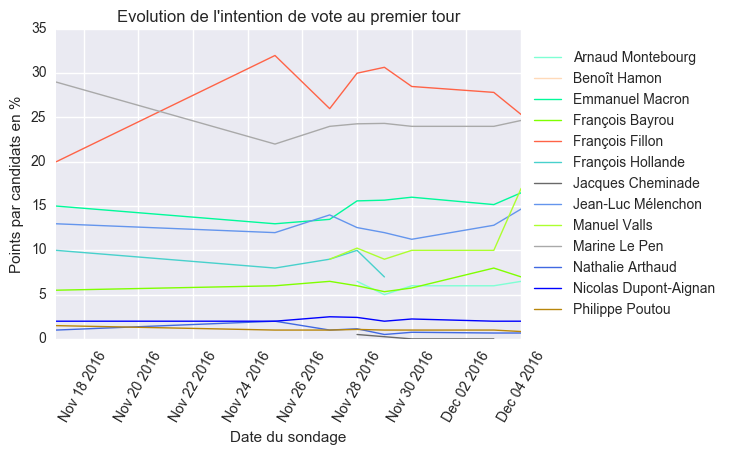

In [6]:
import datetime
plotTable(dfF3[(dfF3["Date"] > datetime.date(2016,10,25)) & (dfF3["Date"] < datetime.date(2016,12,17))])

In [7]:
dfFs2 = dfFs
dfFs2["Date"] = dfFs2["Date"].map(lambda x : x if len(x)>5 else np.nan)
dfFs2 = dfFs2[dfFs2["Date"].notnull()]
dfFs2["Date"] = dfFs2["Date"].map(lambda x : x.replace("-", " ").replace("–", " "))
dfFs2["Date"] = dfFs2["Date"].map(lambda x : x if len(x.split(" ")) < 4 else " ".join(x.split(" ")[2:]))
dfFs2["Date"] = dfFs2["Date"].map(lambda x : dateparser.parse(x).date())
dfFs2 = dfFs2.sort_values('Date', ascending=1)

notCandidats = ["Date", "Sondeur", "Échantillon"]

for col in dfFs2.columns:
    if col not in notCandidats: 
        dfFs2[col] = dfFs2[col].map(lambda x: x if isinstance(x, float) else np.nan)
dfFs2.to_csv("C:\\Users\\Mohamed\\MS BGD\\fil_rouge_lepoint\\Sondages\BVA\\sondages2e.csv")


C:\Users\Mohamed\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Mohamed\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Mohamed\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

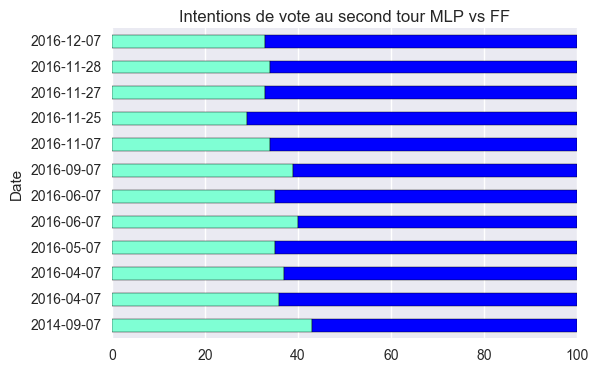

In [8]:
from itertools import cycle, islice

#dfF3["Date"] = dfF3["Date"].map(lambda x : dateparser.parse(x).date())
dfFs2[(dfFs2["Marine Le Pen"].notnull()) & (dfFs2["François Fillon"].notnull()) ]
temp = dfFs2[(dfFs2["Marine Le Pen"].notnull()) & (dfFs2["François Fillon"].notnull())]
df2 = temp[["Marine Le Pen", "François Fillon", "Date"]].set_index("Date")

my_colors = list(islice(cycle(['aquamarine', 'b']), None, len(df2)))

# Specify this list of colors as the `color` option to `plot`.
ax = df2.plot(kind='barh', stacked=True, color=my_colors, title="Intentions de vote au second tour MLP vs FF", legend = False, grid = True)
ax.get_figure().savefig('2nd_tour_v0.png')